<a href="https://colab.research.google.com/github/unknown-jun/First_step_of_data_analist/blob/master/%EC%BD%94%EB%A1%9C%EB%82%98%EC%99%80_%EC%A7%80%ED%95%98%EC%B2%A0_%EC%8A%B9%EA%B0%9D%EC%88%98%EC%99%80%EC%9D%98_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11월, 12월 코로나 신규 확진자 증가세와 서울 유동인구와의 상관관계

1. 코로나 확산세에 따라 지하철 유동인구는 어떻게 변화했을까?

2. 코로나 확산세에 따라 지하철은 노선별로 어떻게 변화했을까?

3. 어느 지역이 가장 변화량이 클까?

4. 다른 교통수단의 경우에도 줄어들었을까?

## 필요한 라이브러리를 불러옵니다

In [ ]:
import matplotlib.pyplot as plt
import mysql.connector
import pandas as pd
import folium
import json
import numpy as np
import webbrowser

plt.rcParams['axes.unicode_minus'] = False

In [ ]:
plt.rc('font', family='NanumGothic')

In [ ]:
config = {
    "user": "root",
    "password": "1234",
    "host": "192.168.56.101", #local
    "database": "orcl", #Database name
    "port": "3456" #port는 최초 설치 시 입력한 값(기본값은 3306)
}

In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()

## 1. 코로나 확산세에 따라 지하철 유동인구는 어떻게 변화했을까?

### 1.1 코로나 추세를 살펴봅니다

In [ ]:
covid=pd.read_csv('/home/scott/Covid_11~12.csv', encoding='cp949')
New_Cases=pd.DataFrame(covid.iloc[2])
New_Cases.drop(['구분별','상태별','항목','단위','Unnamed: 65'], axis=0, inplace=True)
New_Cases=New_Cases.reset_index()
New_Cases.columns=['날짜','신규 확진자 수']
New_Cases['날짜']=pd.date_range(start='2020-11-01',
                                end='2020-12-31')
New_Cases.head()

,날짜,신규 확진자 수
0,2020-11-01,124
1,2020-11-02,97
2,2020-11-03,75
3,2020-11-04,118
4,2020-11-05,125


In [ ]:
New_Cases_Nov=New_Cases.loc[0:29, '신규 확진자 수']
New_Cases_Nov=New_Cases_Nov.reset_index()
New_Cases_Dec=New_Cases.loc[30:61, '신규 확진자 수']
New_Cases_Dec=New_Cases_Dec.reset_index()

Table_New_Cases=pd.concat([New_Cases_Nov,New_Cases_Dec],axis=1)
Table_New_Cases=Table_New_Cases['신규 확진자 수']
Table_New_Cases.index=[ i for i in range(1,32)]
Table_New_Cases.columns=['11월 신규 확진자 수','12월 신규 확진자 수']
Table_New_Cases=Table_New_Cases.fillna(0).astype(int)
Table_New_Cases['누적 변화량']=Table_New_Cases ['12월 신규 확진자 수'].cumsum()-Table_New_Cases ['11월 신규 확진자 수'].cumsum()
Table_New_Cases.head()

,11월 신규 확진자 수,12월 신규 확진자 수,누적 변화량
1,124,451,327
2,97,511,741
3,75,540,1206
4,118,629,1717
5,125,583,2175


누적변화량을 계산하기 위한 데이터 프레임

### 1.2 12월, 11월 지하철 총 승객수에 대한 데이터를 불러옵니다

In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()

seoul_12 = """select 12월날짜,  sum(12월승차인원수)
	from seoul
	group by 12월날짜;"""

seoul_12 = cursor.execute(seoul_12)
resultList = cursor.fetchall()  
df_12 = pd.DataFrame(resultList,columns=['날짜', '12월승차인원수'])

conn.close()

In [ ]:
df_12['날짜']=pd.date_range(start='2020-12-01',
                             end='2020-12-31')
df_12.head()

,날짜,12월승차인원수
0,2020-12-01,5777719
1,2020-12-02,5859462
2,2020-12-03,5801066
3,2020-12-04,5917486
4,2020-12-05,3552439


In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()

seoul_11 = """select 11월날짜,  sum(11월승차인원수)
	from seoul_11
	group by 11월날짜;"""

seoul_11 = cursor.execute(seoul_11)
resultList = cursor.fetchall()  
df_11 = pd.DataFrame(resultList,columns=['날짜', '11월승차인원수'])
conn.close()

In [ ]:
df_11['날짜']=pd.date_range(start='2020-11-01',
                             end='2020-11-30')
df_11.head()

,날짜,11월승차인원수
0,2020-11-01,3175198
1,2020-11-02,6746611
2,2020-11-03,6825713
3,2020-11-04,6847990
4,2020-11-05,6894668


In [ ]:
Total_metro = pd.concat([df_11,df_12],axis=1)

Total_metro.columns=['November','11월승차인원수', 'December','12월승차인원수']
Total_metro =Total_metro[['11월승차인원수','12월승차인원수']].fillna(0).astype(int)
Total_metro['변화율']=(Total_metro ['12월승차인원수']-Total_metro ['11월승차인원수'])/Total_metro ['11월승차인원수']*100
Total_metro['누적 변화량']=Total_metro ['12월승차인원수'].cumsum()-Total_metro ['11월승차인원수'].cumsum()
Total_metro.index=[ i for i in range(1,32)]

conn.close()

In [ ]:
Total_metro.head()

,11월승차인원수,12월승차인원수,변화율,누적 변화량
1,3175198,5777719,81.964054,2602521
2,6746611,5859462,-13.149550,1715372
3,6825713,5801066,-15.011575,690725
4,6847990,5917486,-13.587987,-239779
5,6894668,3552439,-48.475561,-3582008


In [ ]:
avg_11_metro=round(Total_metro ['11월승차인원수'].sum()/30)
avg_12_metro=round(Total_metro ['12월승차인원수'].mean())
total_decreasing=sum(Total_metro ['12월승차인원수']-Total_metro ['11월승차인원수'])

print('11월 평균 하루 지하철 승객수 =',avg_11_metro)
print('12월 평균 하루 지하철 승객수 =', avg_12_metro)
print('한 달간 지하철 승객수 총 변화량 =', total_decreasing)
print('11월 ~12월 기간내 일 평균 변화량 =', avg_12_metro-avg_11_metro)

11월 평균 하루 지하철 승객수 = 5747634
12월 평균 하루 지하철 승객수 = 4520066
한 달간 지하철 승객수 총 변화량 = -32306976
11월 ~12월 기간내 일 평균 변화량 = -1227568


### 1.3 코로나 확산세에 따른 지하철 유동인구를 시각화합니다

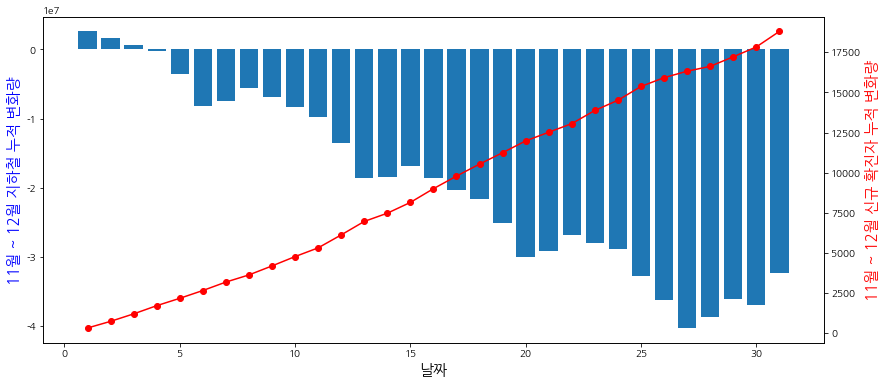

In [ ]:
x = Table_New_Cases.index
y = Total_metro['누적 변화량']

y1 = Table_New_Cases['누적 변화량']
fig, ax1 = plt.subplots(figsize=(14, 6))

ax2 = ax1.twinx()
ax1.bar(x, y)
ax2.plot(x, y1, 'o-', color="red" ) 
ax1.set_xlabel('날짜',size=15)
ax1.set_ylabel('11월 ~ 12월 지하철 누적 변화량', color='b',size=15)
ax2.set_ylabel('11월 ~ 12월 신규 확진자 누적 변화량', color='r',size=15)

plt.show()

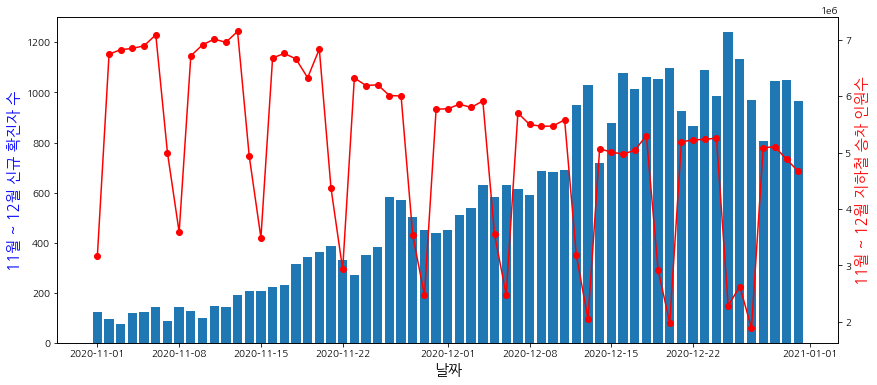

In [ ]:
x = New_Cases['날짜']
y = New_Cases['신규 확진자 수']
y1 = pd.concat([df_11['11월승차인원수'],df_12['12월승차인원수']], axis=0)

fig, ax1 = plt.subplots(figsize=(14, 6))

ax2 = ax1.twinx()
ax1.bar(x, y)
ax2.plot(x, y1, 'o-', color="red" )

ax1.set_xlabel('날짜',size=15)
ax1.set_ylabel('11월 ~ 12월 신규 확진자 수', color='b',size=15)
ax2.set_ylabel('11월 ~ 12월 지하철 승차 인원수', color='r',size=15)


plt.show()

- 지하철의 승차 인원수는 주말에 지하철을 이용하는 승객이 상대적으로 적어 편차가 큼
- 그럼에도 불구하고 코로나와 지하철의 누적 비율으로 보았을때 코로나 증가세에 따라 지하철 승차인원이 줄어듦을 알수 있다

## 코로나의 변화와 지하철 승객 수 변화의 상관분석

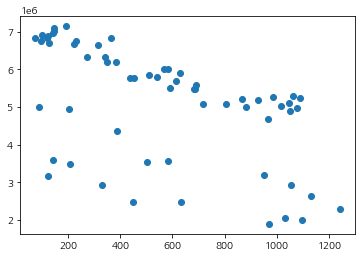

In [ ]:
plt.scatter(New_Cases['신규 확진자 수'],pd.concat([df_11['11월승차인원수'],df_12['12월승차인원수']], axis=0))
plt.show()

In [ ]:
r=New_Cases['신규 확진자 수'].astype('float')
temp = pd.concat([df_11['11월승차인원수'],df_12['12월승차인원수']], axis=0)
r.corr(temp.astype('int'))

-0.31630495559673244

## 2.코로나 확산세에 따라 지하철은 노선별로 어떻게 변화했을까?

In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()
line = """select s12.노선명, sum(11월승차인원수) as 총11월승차인원수, sum(12월승차인원수) as 총12월승차인원수, 
	(sum(12월승차인원수)-sum(11월승차인원수))/sum(11월승차인원수) *100 as 변화율
    from seoul_11 s11 join seoul s12
    on (s11.노선명 = s12.노선명)
    group by s12.노선명
    order by 변화율 asc;"""
line = cursor.execute(line)
resultList = cursor.fetchall()  
line = pd.DataFrame(resultList,columns=['노선명', '총11월승차인원수','총12월승차인원수','변화율'])
conn.close()
line

,노선명,총11월승차인원수,총12월승차인원수,변화율
0,경강선,254640727,188804880,-25.8544
1,공항철도 1호선,1025910900,779664900,-24.0027
2,경춘선,563994594,428927280,-23.9483
3,1호선,1776361690,1357388100,-23.5861
4,중앙선,1524550860,1166102280,-23.5117
5,경의선,2168334205,1661560452,-23.3716
6,장항선,60662598,46533780,-23.2908
7,과천선,609002192,469800720,-22.8573
8,2호선,52982366600,41024998500,-22.5686
9,경부선,13590867108,10528076520,-22.5357


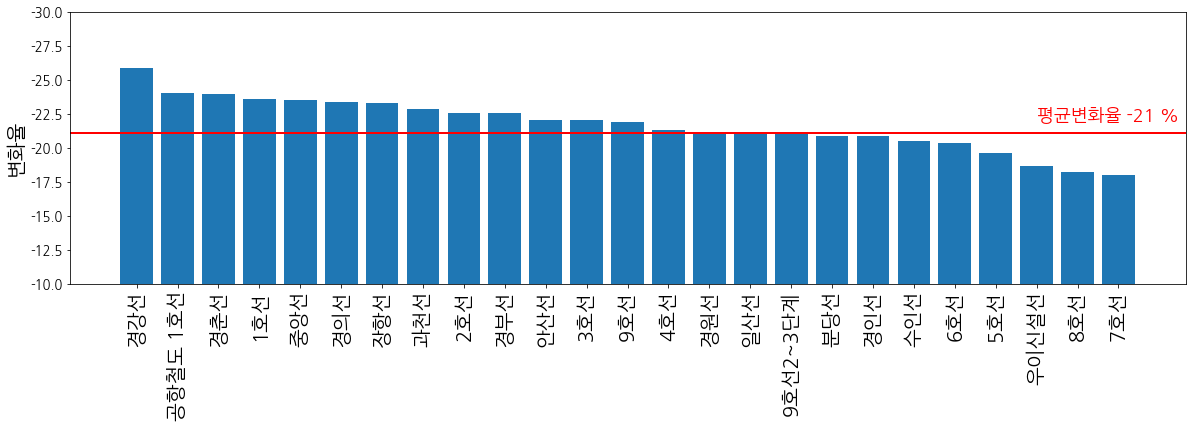

In [ ]:
plt.figure(figsize=(20, 5)) 
plt.bar(line['노선명'], line['변화율'])
plt.ylim(-10, -30)
plt.xticks(rotation='vertical', size=20)
plt.yticks(size=13)
plt.ylabel('변화율',size=20)
avg_change = (sum(line['총12월승차인원수'])-sum(line['총11월승차인원수']))/sum(line['총11월승차인원수']) * 100
plt.axhline(y=avg_change, color='r', linewidth=2)
plt.text(22, -22, '평균변화율 -21 %', size=18,color='r')
plt.show()

In [ ]:
New_line_table=pd.DataFrame(line['총12월승차인원수']-line['총11월승차인원수'], columns=['증감량'])
New_line_table=pd.concat([line['노선명'],New_line_table],axis=1).sort_values(by="증감량", ascending=True)

New_line_table.head()

,노선명,증감량
8,2호선,-11957368100
24,7호선,-4959812628
21,5호선,-4912557810
9,경부선,-3062790588
11,3호선,-2942774253


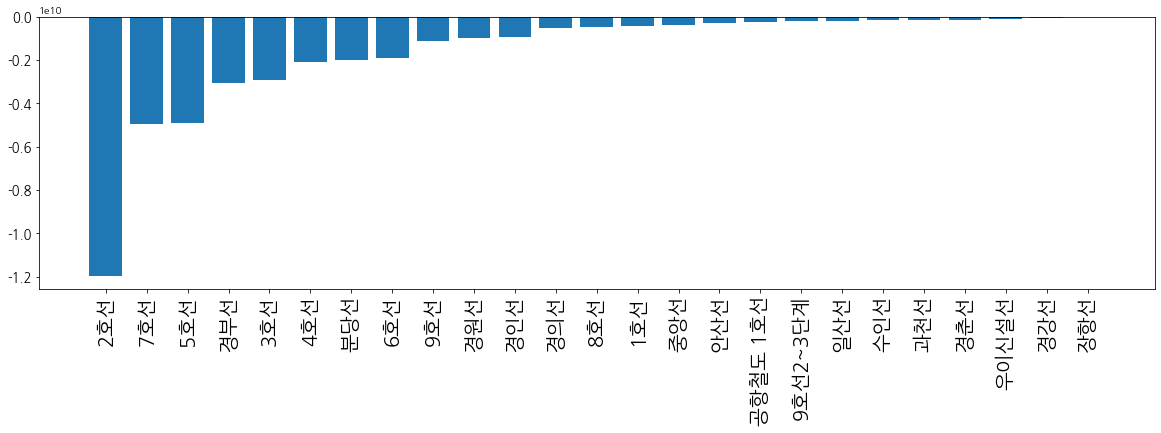

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(New_line_table['노선명'],New_line_table['증감량'])
plt.xticks(rotation='vertical', size=20)
plt.yticks(size=13)
plt.show()

In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()
station_12="""select 역명, sum(12월승차인원수)
	from seoul
    group by 역명;"""

cursor.execute(station_12)
resultList = cursor.fetchall()  
station_12 = pd.DataFrame(resultList)
conn.close()

In [ ]:
station_12.columns=['역명','12월승차인원수']
station_12.head()

,역명,12월승차인원수
0,4.19민주묘지,62349
1,가능,143846
2,가락시장,372324
3,가산디지털단지,1347237
4,가양,433180


In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()
station_11="""select 역명, sum(11월승차인원수)
	from seoul_11
    group by 역명;"""

cursor.execute(station_11)
resultList = cursor.fetchall()  
station_11 = pd.DataFrame(resultList)
conn.close()
station_11.columns=['역명','11월승차인원수']
station_11.head()

,역명,11월승차인원수
0,4.19민주묘지,75412
1,가능,168980
2,가락시장,442072
3,가산디지털단지,1541629
4,가양,520895


In [ ]:
Total_station = pd.merge(station_12,station_11, how='outer', on='역명')
Total_station['증감량']=Total_station['12월승차인원수']-Total_station['11월승차인원수']
Total_station=Total_station.sort_values(by=['증감량'],axis=0)
Total_station.head(10)

,역명,12월승차인원수,11월승차인원수,증감량
11,강남,1607275,2164163,-556888
504,홍대입구,1152421,1667656,-515235
250,서울역,1377602,1867693,-490091
420,잠실(송파구청),1647038,2119805,-472767
34,고속터미널,1438378,1882139,-443761
216,사당,1245647,1640347,-394700
436,종로3가,900459,1228701,-328242
285,수원,901851,1206629,-304778
24,건대입구,969094,1255966,-286872
225,삼성(무역센터),1015280,1294379,-279099


In [ ]:
seoul_map = folium.Map(location=[ 37.5642135, 127.0016985 ], zoom_start=11)

folium.Marker([37.498095,127.027610], popup='강남역 감소량 -> 55만 명').add_to(seoul_map)
folium.Marker([37.5568436,126.9237918], popup='홍대입구역 감소량 -> 51만 명').add_to(seoul_map)
folium.Marker([37.5559234,126.9722685], popup='서울역 감소량 -> 49만 명').add_to(seoul_map)
folium.Marker([37.5133459, 127.1001752], popup='잠실(송파구청)역 감소량 -> 47만 명').add_to(seoul_map)
folium.Marker([37.5060091,127.0043048], popup='고속터미널역 감소량 -> 44만 명').add_to(seoul_map)
folium.Marker([37.4770008, 126.9816814], popup='사당역 감소량 -> 39만 명').add_to(seoul_map)
folium.Marker([37.5704304,126.9921854], popup='종로3가역 감소량 -> 32만 명').add_to(seoul_map)
folium.Marker([37.2664048,126.9999439], popup='수원역 감소량 -> 30만 명').add_to(seoul_map)
folium.Marker([37.5403996,127.069253], popup='건대입구역 감소량 -> 30만 명').add_to(seoul_map)
folium.Marker([37.5088687, 127.0631629], popup='삼성(무역센터)역 감소량 -> 55만 명').add_to(seoul_map)

seoul_map

In [ ]:
location=pd.read_csv('/home/scott/station_info.csv', encoding='cp949')
name_split=location['구주소'].str.split(' ')
location['구정보']=name_split.str.get(1)
info=pd.concat([location['호선'],location['역명'],location['구정보']], axis=1)
info.head()

,호선,역명,구정보
0,1호선,청량리,동대문구
1,1호선,제기동,동대문구
2,1호선,신설동,동대문구
3,1호선,동묘앞,종로구
4,1호선,동대문,종로구


In [ ]:
location=pd.read_csv('/home/scott/station_info.csv', encoding='cp949')
name_split=location['구주소'].str.split(' ')
location['구정보']=name_split.str.get(1)
location.loc[location['구정보']=='탑골공원길3'] = '종로구'
info=pd.concat([location['호선'],location['역명'],location['구정보']], axis=1)
info.head()

,호선,역명,구정보
0,1호선,청량리,동대문구
1,1호선,제기동,동대문구
2,1호선,신설동,동대문구
3,1호선,동묘앞,종로구
4,1호선,동대문,종로구


In [ ]:
Total_station.head()

,역명,12월승차인원수,11월승차인원수,증감량
11,강남,1607275,2164163,-556888
504,홍대입구,1152421,1667656,-515235
250,서울역,1377602,1867693,-490091
420,잠실(송파구청),1647038,2119805,-472767
34,고속터미널,1438378,1882139,-443761


In [ ]:
location_table=pd.merge(info, Total_station, how='inner', left_on="역명",right_on="역명")
location_table

,호선,역명,구정보,12월승차인원수,11월승차인원수,증감량
0,1호선,제기동,동대문구,386051,464202,-78151
1,1호선,신설동,동대문구,435340,514522,-79182
2,2호선,신설동,구로구,435340,514522,-79182
3,1호선,동묘앞,종로구,395187,469976,-74789
4,1호선,동대문,종로구,689184,818254,-129070
...,...,...,...,...,...,...
87,4호선,혜화,종로구,610778,846363,-235585
88,4호선,명동,중구,367554,476835,-109281
89,4호선,삼각지,용산구,207798,261074,-53276
90,4호선,신용산,용산구,301651,397462,-95811


In [ ]:
t=location_table.groupby(['구정보'])
z=t.sum().reset_index()
z.drop(['호선','역명'], axis=1, inplace=True)
z.drop(3, axis=0, inplace=True)      # 경기도인 고양시를 제거
z.sort_values(by='증감량',axis=0)
z

,구정보,12월승차인원수,11월승차인원수,증감량
0,강남구,7091690,8840096,-1748406
1,강북구,625839,743041,-117202
2,강서구,643010,754269,-111259
4,관악구,1956179,2314722,-358543
5,광진구,969094,1255966,-286872
6,구로구,2874521,3490173,-615652
7,노원구,1532384,1843012,-310628
8,도봉구,1234026,1467921,-233895
9,동대문구,1034553,1232431,-197878
10,동작구,3085841,3975636,-889795


In [ ]:
z.drop(['12월승차인원수','11월승차인원수'], axis=1, inplace=True)
z['비율']=(z['증감량']/sum(z['증감량'])*100).apply(round)
z=z.sort_values(by='증감량')

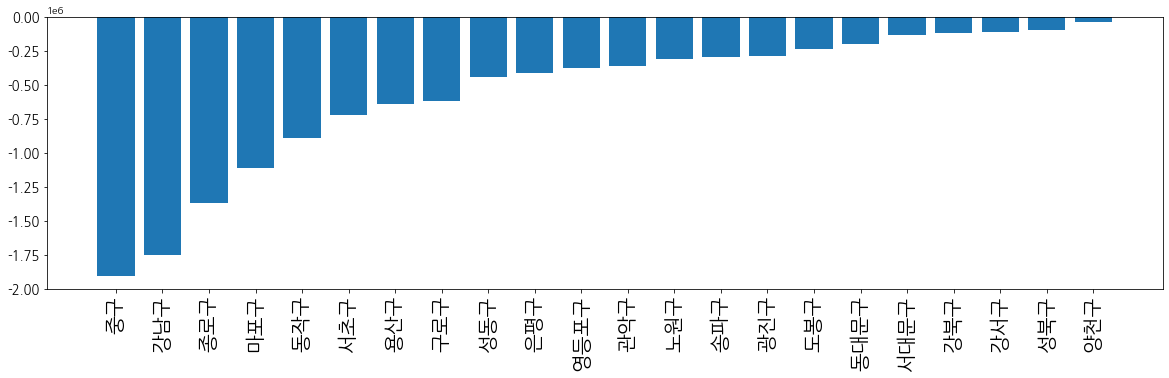

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(z['구정보'],z['증감량'])
plt.xticks(rotation='vertical', size=20)
plt.yticks(size=13)
plt.show()

In [ ]:
geo_json = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
    
location_map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')

location_map.choropleth(geo_data = geo_json,
               data = z,
               columns = ['구정보', '비율'],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.properties.name')
location_map

/home/scott/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## 4.다른 교통수단의 경우에도 줄어들었을까?

### 4-1. 11월, 12월 버스 총 승객수에 대한 데이터를 불러옵니다

In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()
bus_12 = """select 12사용일자, sum( 12승차총승객수 )
	from bus_12
	group by 12사용일자;"""

cursor.execute(bus_12)
resultList = cursor.fetchall()  
bus_12 = pd.DataFrame(resultList)
conn.close()

In [ ]:
bus_12[0]=pd.date_range(start='2020-12-01',
                             end='2020-12-31')
bus_12.columns=['12월','12월 승차총승객수']
bus_12.head()

,12월,12월 승차총승객수
0,2020-12-01,4096780
1,2020-12-02,4220894
2,2020-12-03,4113823
3,2020-12-04,4109832
4,2020-12-05,2678735


In [ ]:
conn = mysql.connector.connect(**config)
cursor = conn.cursor()
bus_11 = """select 11사용일자, sum( 11승차총승객수  )
	from bus_11
    group by 11사용일자;"""
cursor.execute(bus_11)
resultList = cursor.fetchall()  
bus_11 = pd.DataFrame(resultList)
conn.close()

In [ ]:
bus_11[0]=pd.date_range(start='2020-11-01',
                             end='2020-11-30')
bus_11.columns=['11월','11월 승차총승객수']
bus_11.head()

,11월,11월 승차총승객수
0,2020-11-01,2363381
1,2020-11-02,4796757
2,2020-11-03,4875158
3,2020-11-04,4881139
4,2020-11-05,4890992


In [ ]:
Total_bus = pd.concat([bus_11,bus_12],axis=1)

Total_bus.columns= ['November','11월승차인원수', 'December','12월승차인원수']
Total_bus = Total_bus[['11월승차인원수','12월승차인원수']].fillna(0).astype(int)
Total_bus['변화율']=(Total_bus ['12월승차인원수']-Total_bus ['11월승차인원수'])/Total_bus ['11월승차인원수']*100
Total_bus['누적 변화량']=Total_bus['12월승차인원수'].cumsum() - Total_bus['11월승차인원수'].cumsum()
Total_bus.index=[ i for i in range(1,32) ]

Total_bus.head()

,11월승차인원수,12월승차인원수,변화율,누적 변화량
1,2363381,4096780,73.344036,1733399
2,4796757,4220894,-12.005257,1157536
3,4875158,4113823,-15.616622,396201
4,4881139,4109832,-15.801783,-375106
5,4890992,2678735,-45.231254,-2587363


In [ ]:
avg_11_bus=round(Total_bus['11월승차인원수'].sum()/30)
avg_12_bus=round(Total_bus['12월승차인원수'].mean())
total_decreasing=sum(Total_metro ['12월승차인원수']-Total_metro ['11월승차인원수'])

print('11월 평균 하루 버스 승객수 =',avg_11_bus)
print('12월 평균 하루 버스 승객수 =', avg_12_bus)
print('한 달간 버스 승객수 총 변화량 =', total_decreasing)
print('11월 ~12월 기간내 일 평균 변화량 =', avg_12_bus-avg_11_bus)

11월 평균 하루 버스 승객수 = 4111837
12월 평균 하루 버스 승객수 = 3280108
한 달간 버스 승객수 총 변화량 = -32306976
11월 ~12월 기간내 일 평균 변화량 = -831729


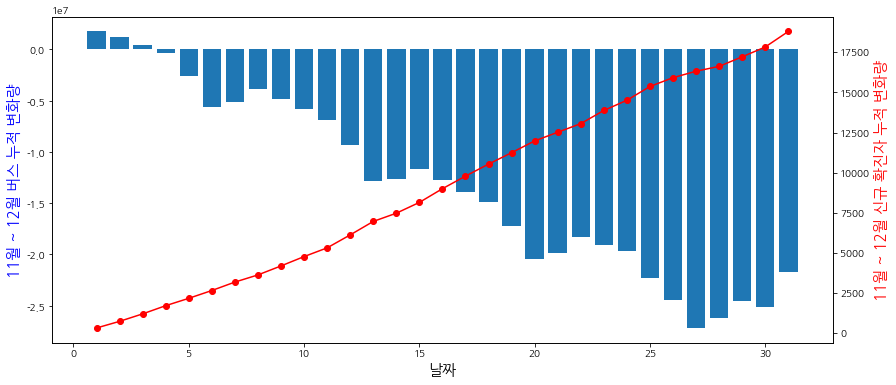

In [ ]:
x = Table_New_Cases.index
y = Total_bus['누적 변화량']

y1 = Table_New_Cases['누적 변화량']
fig, ax1 = plt.subplots(figsize=(14, 6))

ax2 = ax1.twinx()
ax1.bar(x, y)
ax2.plot(x, y1, 'o-', color="red" ) 
ax1.set_xlabel('날짜',size=15)
ax1.set_ylabel('11월 ~ 12월 버스 누적 변화량', color='b',size=15)
ax2.set_ylabel('11월 ~ 12월 신규 확진자 누적 변화량', color='r',size=15)

plt.show()

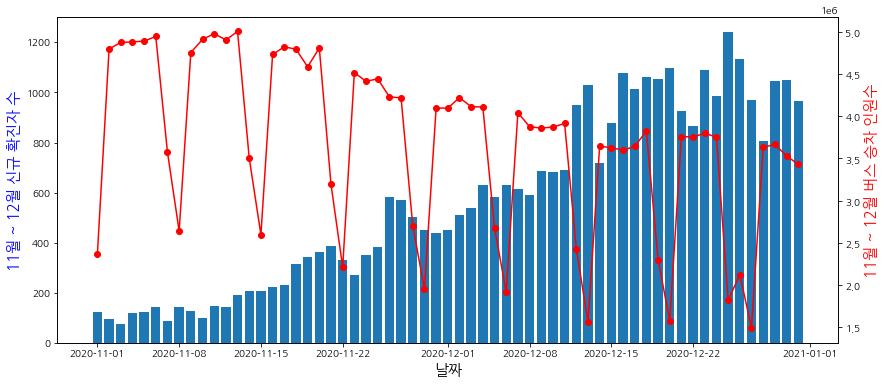

In [ ]:
x = New_Cases['날짜']
y = New_Cases['신규 확진자 수']
y1 = pd.concat([bus_11['11월 승차총승객수'],bus_12['12월 승차총승객수']], axis=0)

fig, ax1 = plt.subplots(figsize=(14, 6))

ax2 = ax1.twinx()
ax1.bar(x, y)
ax2.plot(x, y1, 'o-', color="red" )

ax1.set_xlabel('날짜',size=15)
ax1.set_ylabel('11월 ~ 12월 신규 확진자 수', color='b',size=15)
ax2.set_ylabel('11월 ~ 12월 버스 승차 인원수', color='r',size=15)


plt.show()